Puschase probability prediction

In [46]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

In [47]:
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [48]:
# Data loading
data = pd.read_csv('Data/training_sample.csv')

In [51]:
data.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,1


In [49]:
data['ordered'].value_counts()

ordered
0    436308
1     19093
Name: count, dtype: int64

Podział na zbiór treningowy i testowy z równymi proporcjami klas

In [56]:
# Splitting data into features and target variable
X = data.drop(columns=['ordered', 'UserID'])
y = data['ordered']

# Train test sets split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Combining features and target for the training set
train_data = pd.concat([X_train, y_train], axis=1)

# Undersampling the dominant class (class 0)
majority = train_data[train_data['ordered'] == 0]
minority = train_data[train_data['ordered'] == 1]

majority_undersampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

# Creating a balanced training set
train_balanced = pd.concat([majority_undersampled, minority])

# Separating features and target
X_train_balanced = train_balanced.drop(columns=['ordered'])
y_train_balanced = train_balanced['ordered']


In [57]:
# Model building and training
model_1 = LogisticRegression(random_state=42, max_iter=1000)

model_1.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [58]:
# Probability prediction for test set
y_pred_proba = model_1.predict_proba(X_test)[:, 1]

# Adding probability feature to test set
X_test_with_proba = X_test.copy()
X_test_with_proba['probability_ordered'] = y_pred_proba

# Classification based on treshols = 0.5
y_pred = model_1.predict(X_test)

# Merging the test set with actual labels and UserID
X_test_with_proba['UserID'] = data.loc[X_test.index, 'UserID']
X_test_with_proba['ordered_actual'] = y_test.values
X_test_with_proba['ordered_predicted'] = y_pred


Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87262
           1       0.85      0.99      0.92      3819

    accuracy                           0.99     91081
   macro avg       0.92      0.99      0.96     91081
weighted avg       0.99      0.99      0.99     91081

Confusion matrix:
[[86594   668]
 [   32  3787]]
AUC Score: 0.9973


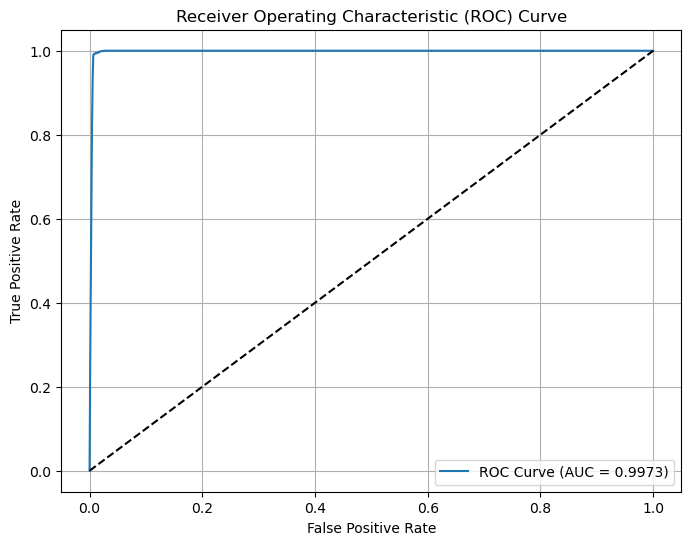

In [59]:
# CLassification raport
print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

In [62]:
# Adding classification probability to DataFrame
data['probability_ordered'] = model_1.predict_proba(data.drop(columns=['ordered', 'UserID']))[:, 1]


In [66]:
data.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,probability_ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.016171
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.000054
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0.000085
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0.000085
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,1,0.980103


In [69]:
# Displaying sample results
print('DataFrame with probabilities:') 
print(data[['UserID', 'ordered', 'probability_ordered']].head())


DataFrame with probabilities:
                                UserID  ordered  probability_ordered
0  a720-6b732349-a720-4862-bd21-644732        0             0.016171
1  a0c0-6b73247c-a0c0-4bd9-8baa-797356        0             0.000054
2  86a8-6b735c67-86a8-407b-ba24-333055        0             0.000085
3  6a3d-6b736346-6a3d-4085-934b-396834        0             0.000085
4  b74a-6b737717-b74a-45c3-8c6a-421140        1             0.980103


In [73]:
# Filtering rows where the probability is greater than or equal to 0.8
high_probability_cases = data[data['probability_ordered'] >= 0.80]

print("Rows with probability >= 0.8:")
display(high_probability_cases)

Rows with probability >= 0.8:


,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,probability_ordered
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,1,0.980103
47,6797-6b7bc767-6797-465a-b562-175804,1,1,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0.996700
56,c773-6b7d6430-c773-4db1-90d0-503545,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,1,0.992122
62,aa34-6b760410-aa34-4ba5-b260-433850,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,1,1,0.996710
66,47b6-6b76a765-47b6-4b64-8743-628618,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0.980627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455307,6070-06d006d2-6070-41c6-ad54-391208,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,0.995429
455320,6903-06d168d8-6903-4363-95b7-698282,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,1,1,1,0.990510
455337,717b-06d59cc5-717b-41e7-a477-385589,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0.996710
455360,0b47-06d8d2d4-0b47-43av-974c-667079,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0.988785


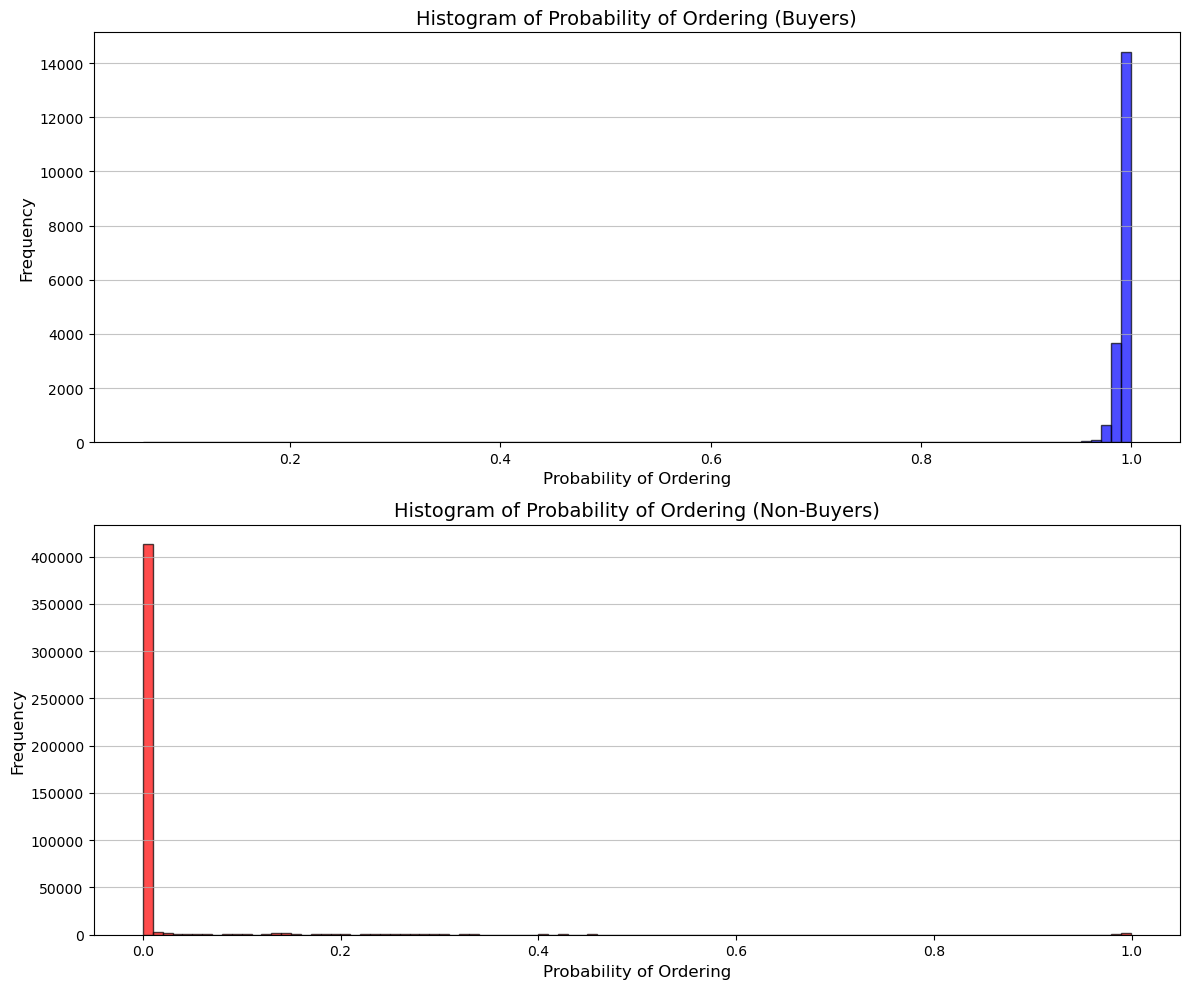

In [87]:
# Distribution shape of probability_ordered separately for buyers and non-buyers
# Filtering data
buyers = data[data['ordered'] == 1]
non_buyers = data[data['ordered'] == 0]

plt.figure(figsize=(12, 10))

# Buyers histogram
plt.subplot(2, 1, 1)
plt.hist(buyers['probability_ordered'], bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Probability of Ordering (Buyers)', fontsize=14)
plt.xlabel('Probability of Ordering', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)

# Non_buyers histogram
plt.subplot(2, 1, 2)
plt.hist(non_buyers['probability_ordered'], bins=100, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram of Probability of Ordering (Non-Buyers)', fontsize=14)
plt.xlabel('Probability of Ordering', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


In [89]:
data.to_csv('Data/data_with_prob.csv')